<a href="https://colab.research.google.com/github/KCachel/fairranktune/blob/main/examples/1_quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

We need to install [FairRankTune](https://kcachel.github.io/fairranktune/).

In [1]:
!pip install FairRankTune

We need to import FairRankTune along with some other packages.

In [2]:
import FairRankTune as frt
import numpy as np
import pandas as pd
from FairRankTune import RankTune, Metrics, Rankers
import matplotlib.pyplot as plt

# RankTune (Data Generation)
The [RankTune](https://kcachel.github.io/fairranktune/ranktune/) data generator allows for quickly generating high-volumes of unfair rankings.

RankTune is a pseudo-stochastic data generation method for creating fairness-aware ranked lists using the fairness concept of statistical parity. Inlcuded in the `RankTune` module, it creates ranking(s) based on the `phi` representativeness parameter. When `phi = 0` then the generated ranked list(s) does not represent groups fairly, and as `phi` increases groups are represented more and more fairly; thus `phi = 1` groups are fairly represented. RankTune uses a [pseudo-random process](https://kcachel.github.io/fairranktune/ranktune/#how-does-it-work) to generate fairness-aware ranked data. RankTune can generate ranked data from [user provided group sizes](https://kcachel.github.io/fairranktune/ranktune/#using-group-sizes), from [existing datasets](https://kcachel.github.io/FairRankTune/RankTune/#using-an-existing-dataset), along with [producing relevance scores](https://kcachel.github.io/fairranktune/ranktune/#generating-scores-with-the-ranking) accompanying the ranked list(s).


Here, we will quickly show that Ranktune is able to generate rankings form unfair to more representative of groups using the `phi` parameter.


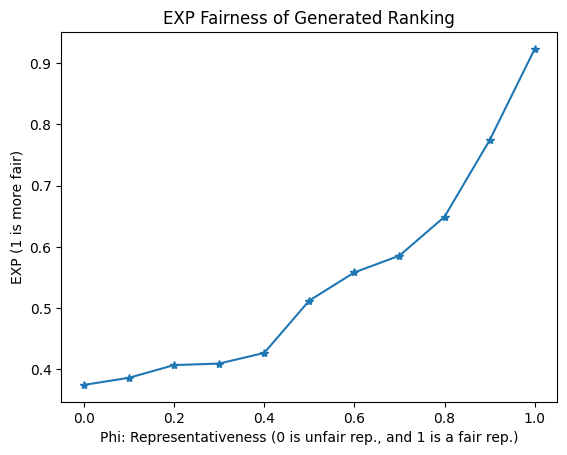

In [3]:
#ranking of 1000 items, with five groups of 40, 60, 200, 300, and 400 items each
group_proportions = np.asarray([.04, .06, .2, .3, .4]) #Array of group proportions
num_items = 1000
r_cnt = 1 #Generate 1 ranking
seed = 10 #For reproducability


# For plotting
er_plot = []
phi_plot = []

for phi in [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]:
    ranking_df, item_group_dict = frt.RankTune.GenFromGroups(group_proportions, num_items, phi, r_cnt, seed)
    expdp, avg_exps = frt.EXP(ranking_df, item_group_dict, 'MinMaxRatio')
    er_plot.append(expdp)
    phi_plot.append(phi)


#plot EXP
xpoints = phi_plot
ypoints = er_plot
plt.ylabel("EXP (1 is more fair)")
plt.xlabel("Phi: Representativeness (0 is unfair rep., and 1 is a fair rep.)")
plt.title("EXP Fairness of Generated Ranking")
plt.plot(xpoints, ypoints, marker='*')
plt.show()


We can see that as `phi` increase so does the EXP value, indicating we are generating fairer rankings.

For this overview we will generate data from from `group_proportions`, a numpy array with each group's proportion of the total items,`num_items`, by using the `ScoredGenFromGroups()` function.  Scores are generated from either a normal or uniform distribution by setting the `score_dist` parameter to either ```normal``` or ```uniform```.

In [4]:
#Generate a biased (phi = 0.1) ranking of 1000 items, with four groups of 100, 200, 300, and 400 items each.
group_proportions = np.asarray([.1, .2, .3, .4]) #Array of group proportions
num_items = 1000 #1000 items to be in the generated ranking
phi = 0.1
r_cnt = 1 #Generate 1 ranking
seed = 10 #For reproducability
score_dist = "uniform"
ranking_df, item_group_dict, scores_df = frt.RankTune.ScoredGenFromGroups(group_proportions, num_items, phi, r_cnt, score_dist, seed)

# Metrics (Evaluate Data Generation & Fair Ranking)
FairRankTune provides 10 [fair ranking metrics](https://kcachel.github.io/fairranktune/metrics/) in the `Metrics` module. In this overview we will use group fairness of Exposure [EXP](https://kcachel.github.io/fairranktune/metrics/#group-exposure-exp) and Normalized-discounted KL-divergence [NDKL](https://kcachel.github.io/fairranktune/metrics/#normalized-discounted-kl-divergence-ndkl).

A key functionality of FairRankTune is providing toolkit users multiple choices for how to calculate a given top-level fairness metric. For instance, for EXP,  `Metrics` offers seven ways of calculating a top-level exposure metric (e.g., min-max ratios, max absolute difference, L-2 norms of per-group exposures, etc.).

In this notebook we will calculate EXP with a `'MinMaxRatio'`, so it's range is [0, 1] where *1 is most fair*. NDKL is not meta-metric composable and it's range is [0, ∞] where *0 is most fair*.

## Calculate EXP fairness of previously generated ranking

In [5]:
#Calculate EXP with a MinMaxRatio
EXP_minmax, avg_exposures = frt.Metrics.EXP(ranking_df, item_group_dict, 'MinMaxRatio')
print("EXP (most fair at 1): ", EXP_minmax, "Average exposures for each group: ", avg_exposures)

EXP (most fair at 1):  0.511665941043515 Average exposures for each group:  {0: 0.20498798214669187, 1: 0.13126425437156242, 2: 0.11461912123646827, 3: 0.10488536878769836}


We can see the EXP indicates the generated ranking is pretty unfair. This is expected since we set `phi = 0.1` and `phi` ranges from unfair (`phi = 0`) to fairest representatation (`phi = 1`).



## Calculate NDKL fairness of previously generated ranking

In [6]:
#Calculate NDKL
NDKL= frt.Metrics.NDKL(ranking_df, item_group_dict)
print("NDKL (most fair at 0): ", NDKL)

NDKL (most fair at 0):  0.7858194402275921


We can see that NDKL also indicates the generated ranking is pretty unfair.

# Rankers (Re-rank generated ranking to be fair)

FairRankTune provides [fair ranking algorithms](https://kcachel.github.io/fairranktune/rankers/#supported-fair-ranking-algorithms) in the `Rankers` module. These fair ranking algorithms can be used to re-rank a given ranking with the objective of making the resulting ranking fair.

Here we will use the [Epsilon-Greedy algorithm](https://kcachel.github.io/fairranktune/rankers/#epsilon-greedy-re-ranker). Epsilon-Greedy takes as input a ranking and repeatedly swaps pairs of items so that each item has probability $\epsilon$ (`epsilon`) of swapping with a random item below it. It does not require a specific notion of fairness or prior knowledge of group distributions. It does use random swapping, thus it is recommended to set a random seed for reproducability. To learn more see [Feng et al.](https://doi.org/10.1609/aaai.v36i11.21445).

In [7]:
#Rerank using Epsilon-Greedy
seed = 2 #For reproducability
epsilon = .6
reranking_df, item_group_d, reranking_scores = frt.Rankers.EPSILONGREEDY(ranking_df, item_group_dict, scores_df, epsilon, seed)

Now we will compare the EXP and NDKL metrics to those calculated prior to the fair ranking algorithm.

In [8]:
#Calculate EXP with a MinMaxRatio post Epsilon-Greedy
EXPpost, avg_exposures_post= frt.Metrics.EXP(reranking_df, item_group_d, 'MinMaxRatio')
print("EXP (more fair at 1) after Epsilon-Greedy: ", EXPpost, "avg_exposures after Epsilon-Greedy: ", avg_exposures_post)

EXP (more fair at 1) after Epsilon-Greedy:  0.7489965299172665 avg_exposures after Epsilon-Greedy:  {0: 0.15469032884066963, 1: 0.12633302018059972, 2: 0.12003629416481872, 3: 0.1158625195134224}


We can see EXP increased from 0.511 to 0.748 indicating the ranking was adjusted to be fairer.

In [9]:
#Calculate NDKL post Epsilon-Greedy
NDKLpost= frt.Metrics.NDKL(reranking_df, item_group_d)
print("NDKL (more fair at 0) after Epsilon-Greedy: ", NDKLpost)

NDKL (more fair at 0) after Epsilon-Greedy:  0.14287220595846148


We can see NDKL decreased (became more fair) from 0.785 to 0.145 after Epsilon-Greedy.